In [2]:
# connect to test.db sqlite, create session, then run "get all users" with session.Query
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
from models import Base, Cast, User, Reaction, Location, parent_association
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


engine = create_engine('sqlite:///data.db')
Session = sessionmaker(bind=engine)
session = Session()


In [3]:
"""
Place all models in the notebook so Copilot knows what it's working with

Here are all the available models:
parent_association = Table('parent_association', Base.metadata,
                           Column('parent_hash', String,
                                  ForeignKey('casts.hash')),
                           Column('cast_hash', String,
                                  ForeignKey('casts.hash'))
                           )


# figure out ancestor hashes later
class Cast(Base):
    __tablename__ = 'casts'
    hash = Column(String, primary_key=True)
    thread_hash = Column(String, ForeignKey(
        'casts.hash'))
    parent_hash = Column(String, ForeignKey(
        'casts.hash'), nullable=True)
    text = Column(String)
    timestamp = Column(BigInteger)
    author_fid = Column(BigInteger, ForeignKey(
        'users.fid'))
    author = relationship('User', back_populates='casts')
    reactions = relationship('Reaction', back_populates='target')
    children_hashes = relationship("Cast", secondary=parent_association,
                                   primaryjoin=(
                                       hash == parent_association.c.parent_hash),
                                   secondaryjoin=(
                                       hash == parent_association.c.cast_hash),
                                   backref="parent_casts")


class Reaction(Base):
    __tablename__ = 'reactions'
    hash = Column(String, primary_key=True)
    reaction_type = Column(String)  # like & recast
    timestamp = Column(BigInteger)
    target_hash = Column(String, ForeignKey('casts.hash'))
    author_fid = Column(BigInteger, ForeignKey('users.fid'))
    target = relationship('Cast', back_populates='reactions')


class Location(Base):
    __tablename__ = 'locations'
    place_id = Column(String, primary_key=True)
    description = Column(String)
    users = relationship('User', backref='location')


class User(Base):
    __tablename__ = 'users'
    fid = Column(BigInteger, primary_key=True)
    username = Column(String)
    display_name = Column(String)
    verified = Column(Boolean, default=False)
    pfp_url = Column(String, nullable=True)
    follower_count = Column(BigInteger)
    following_count = Column(BigInteger)
    bio_text = Column(String, nullable=True)
    location_place_id = Column(String, ForeignKey(
        'locations.place_id'), nullable=True)
    casts = relationship('Cast', back_populates='author')

"""

'\nPlace all models in the notebook so Copilot knows what it\'s working with\n\nHere are all the available models:\nparent_association = Table(\'parent_association\', Base.metadata,\n                           Column(\'parent_hash\', String,\n                                  ForeignKey(\'casts.hash\')),\n                           Column(\'cast_hash\', String,\n                                  ForeignKey(\'casts.hash\'))\n                           )\n\n\n# figure out ancestor hashes later\nclass Cast(Base):\n    __tablename__ = \'casts\'\n    hash = Column(String, primary_key=True)\n    thread_hash = Column(String, ForeignKey(\n        \'casts.hash\'))\n    parent_hash = Column(String, ForeignKey(\n        \'casts.hash\'), nullable=True)\n    text = Column(String)\n    timestamp = Column(BigInteger)\n    author_fid = Column(BigInteger, ForeignKey(\n        \'users.fid\'))\n    author = relationship(\'User\', back_populates=\'casts\')\n    reactions = relationship(\'Reaction\', back_

In [4]:
# get all users where they have location with description that contains "USA"
# description_location is from the Location model
# location_place_id is from the User model

locations = session.query(Location).filter(
    Location.description.contains("USA")).all()

# print users with locations
users = session.query(User).filter(
    User.location_place_id.in_([location.place_id for location in locations])).all()

df = pd.DataFrame([user.__dict__ for user in users])
# print(df)

# make df with username, location column

new_df = pd.DataFrame(columns=["username", "location"])
for user in users:
    new_df = pd.concat([new_df, pd.DataFrame({"username": [user.username], "location": [user.location.description]})], ignore_index=True)

print(new_df)

          username                location
0                v    Los Angeles, CA, USA
1              dwr    Los Angeles, CA, USA
2               mp  San Francisco, CA, USA
3            b-rad          Miami, FL, USA
4              sds  San Francisco, CA, USA
..             ...                     ...
410          bayka        Seattle, WA, USA
411          vladn          Miami, FL, USA
412  thelafffinman      San Diego, CA, USA
413      ericnagel        Buffalo, NY, USA
414       das-mchl       New York, NY, USA

[415 rows x 2 columns]


In [5]:
casts_with_no_parent = session.query(
    Cast).filter(Cast.parent_hash == None).all()

all_associations = session.query(parent_association).all()

all_casts = session.query(Cast).all()

print(len(all_casts) - len(casts_with_no_parent) == len(all_associations))
print(len(all_casts), len(casts_with_no_parent), len(all_associations))


True
610139 240813 369326


11
nt
slowcrypto
lsl
lukaslevert
thepaulbalaji
esskayen
sheftali
userman
praven
tonysellen
daish


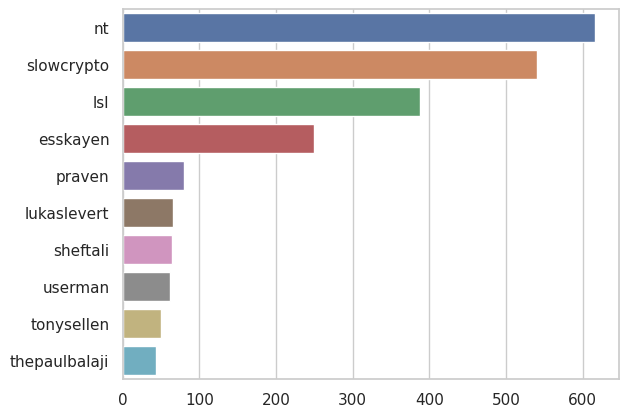

In [13]:
# get all users who are in the UK

uk_locations = session.query(Location).filter(
    Location.description.contains("UK")).all()

uk_users = session.query(User).filter(
    User.location_place_id.in_([location.place_id for location in uk_locations])).all()

# just print the usernames
print(len(uk_users))
for user in uk_users:
    print(user.username)

# from all these uk users, sort by follower

uk_users.sort(key=lambda user: user.follower_count, reverse=True)

# seaborn plot

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=[user.follower_count for user in uk_users[:10]], y=[user.username for user in uk_users[:10]])

For tax purposes, a DAO is a partnership by default, but can declare as a corporation by public vote.

A DAO shall allocate the distributive share of income, gain, loss, deduction, and credit derived to each member in proportion to the member's membership interest in the entity.
DAO does not have an administrator, all members are considered co-administrators.

Members are not personally liable. However, if DAO refuses to comply with an enforceable judgment or order. Member who vote to not compliace may be liable for monetary payments.
In addition to this, the bill provides a clear definition of members and responsibilities.

However, only deployments on permissionless blockchains that maintain open source code and have decentralized governance  are eligible for registration as a limited liability DAO in Utah.
We used to register LLC, UNA, Foundation, Co-op for tax/liability protection and affair for DAO. It is essentially adding a legal wrapper to DAOs, it is effective but has some lim